Khai báo thư viện

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
import warnings
warnings.filterwarnings("ignore")

Lấy đường dẫn dữ liệu

In [3]:
image=PIL.Image.open("./dataset/train/001d7af96b.jpg")
height,width=image.size
print(height,width)

308 164


In [4]:
train_data=pd.read_csv("./dataset/train.csv")
train_data.head()

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket


In [5]:
train_data["label"].values

array(['Badminton', 'Badminton', 'Badminton', ..., 'Tennis', 'Tennis',
       'Swimming'], dtype=object)

In [6]:
image_to_label_map=dict(zip(train_data["image_ID"].values,train_data["label"].values))

In [7]:
# Lấy ra tên các nhãn có trong tập dữ liệu
unique_classes=train_data["label"].unique()
print(unique_classes)
print(len(unique_classes))

['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']
7


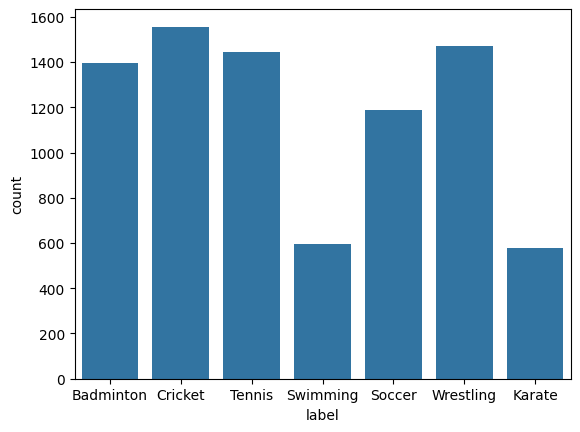

In [8]:
sns.countplot(data=train_data,x="label");

In [9]:
from os import makedirs
#Tạo các thư mục
dataset_home="./"
subdirs=["train/","validation/"]

for subdir in subdirs:
    # Tạo các thư mục nhãn
    labeldirs=unique_classes
    for label in labeldirs:
        new_dir=dataset_home+subdir+label+"/"
        makedirs(new_dir,exist_ok=True)

Tách tập dữ liệu ra làm 2 phần để train và validate với tỷ lệ 80:20

In [ ]:
from shutil import copyfile
from os import listdir

import random
from random import seed
# Định nghĩa tỷ lệ chia
val_ratio=0.20
# Copy ảnh chuyển ra các folder với tên nhãn riêng
src_directory="./dataset/train"
for file in listdir(src_directory):
    src=src_directory+"/"+file
    dst_directory="./train/"
    if(random.random()<val_ratio):
        dst_directory="./validation/"
    dst=dst_directory+"/"+str(image_to_label_map[file])+"/"+file #ảnh có nhãn nào sẽ thuộc về folder đó
    copyfile(src,dst)

In [10]:
# Create DataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,#chuẩn hóa 0-1
    rotation_range=40, #Xoay ngẫu nhiên
    width_shift_range=0.2, #dịch ngang ngẫu nhiên -20 đến 20%
    height_shift_range=0.2, #dịch lên ...
  #  shear_range=0.2, #biến dạng ngẫu nhiên -20 : 20
  #  zoom_range=0.2,#zoom ngẫu nhiên
    horizontal_flip=True, #lật ngẫu nhiên
    fill_mode="nearest" #điền vào pixel trống bằng pixel gần nhất
)
test_datagen=ImageDataGenerator(rescale=1./255) #dữ liệu test thì giữ nguyên hình dạng

In [11]:
train_directory="./train"
validation_directory="./validation"
#định nghĩa kích thước ảnh và bactch_size
img_height,img_width=224,224
batch_size=128
train_generator=train_datagen.flow_from_directory(
    train_directory,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode="categorical"
)
validation_generator=test_datagen.flow_from_directory(
    validation_directory,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 6550 images belonging to 7 classes.
Found 1677 images belonging to 7 classes.


In [12]:
train_generator.image_shape

(224, 224, 3)

In [13]:
vgg_base_model=keras.applications.VGG16(
weights="imagenet",   # Lấy trọng số đc huấn luyện sẵn từ ImageNet dataset
input_shape=(224,224,3),
include_top=False) #không lấy 3 lớp fully connected layers.

In [14]:
for l in vgg_base_model.layers: #in ra các lớp sử dụng trong model
    print(l.name,l.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [15]:
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
for l in vgg_base_model.layers[:-4]: #chỉ sử dụng vào 4 đặc trưng quan trọng nhất của ảnh
    l.trainable=False

In [17]:
for l in vgg_base_model.layers:
    print(l.name, l.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


Định nghĩa model huấn luyện để phân loại, với đầu vào là ảnh 224,224,3 ra đầu ra là lớp phân loại cho 7 nhãn

In [18]:
inputs=keras.Input(shape=(224,224,3))
x=vgg_base_model(inputs) #sử dụng mô hình VGG16 để trích chọn các đặc trưng ảnh
x=keras.layers.GlobalAveragePooling2D()(x) #trung bình các đặc trưng về vector 2D
x=keras.layers.Dense(512,activation="relu")(x) #tạo lớp ẩn khác với 512 neuron
x=keras.layers.Dropout(0.3)(x) #Tỷ lệ các neuron được tắt là 0.3 để tránh overfit
outputs=keras.layers.Dense(7,activation="softmax")(x) #Tạo lớp đầu ra để phân lớp
model=keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                             

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('ModelVGG16_Classification.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')
model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[earlyStopping, mcp_save, reduce_lr_loss]) 

Epoch 1/30
52/52 [==============================] - 1716s 33s/step - loss: 1.9620 - accuracy: 0.1837 - val_loss: 1.8749 - val_accuracy: 0.2129 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 1772s 34s/step - loss: 1.8556 - accuracy: 0.2217 - val_loss: 1.8056 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 1810s 35s/step - loss: 1.7388 - accuracy: 0.3002 - val_loss: 1.6032 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 1873s 36s/step - loss: 1.5360 - accuracy: 0.3937 - val_loss: 1.4071 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 5/30
52/52 [==============================] - 1757s 34s/step - loss: 1.3156 - accuracy: 0.4815 - val_loss: 1.1396 - val_accuracy: 0.5522 - lr: 0.0010
Epoch 6/30
52/52 [==============================] - 1762s 34s/step - loss: 1.0817 - accuracy: 0.5730 - val_loss: 0.8286 - val_accuracy: 0.6959 - lr: 0.0010
Epoch 7/30
52/52 [==============================] - 1757s 34s/st

In [21]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.3750005066394806
Val accuracy: 0.8980321884155273
